In [6]:
import os
import numpy as np
from scipy.interpolate import interp1d
from tabulate import tabulate
from cideMOD import (
    CellParser,
    ErrorCheck,
    NDProblem,
    Problem,
    SolverCrashed,
    Trigger,
    init_results_folder,
    ModelOptions,
)

In [ ]:
overwrite = True
case = "Chen_2020"
data_path = f"../../data/data_{case}"
params = "params_tuned.json"

model_options = ModelOptions(mode='P2D', clean_on_exit=False)

save_path = init_results_folder(
    case, overwrite=overwrite, copy_files=[f"{data_path}/{params}"]
)

In [8]:
cell = CellParser(params, data_path=data_path, log=True)
problem = Problem(cell, model_options, save_path=save_path)
problem.set_cell_state(1, 273 + 25, 273 + 25)
problem.setup()
C_rate = -1
I_app = -5 #C_rate * problem.Q
t_f = 3600 /abs(C_rate)*1.25

Negative electrode capacity: 5.090422
Positive electrode capacity: 5.574712
--------------------
Cell capacity: 5.090422

Building mesh for P2D problem with 3 components and 90 nodes.
Finished building mesh
Building problem setup
 - Build cell parameters - Done 
 - Initializing state - Done 
 - Build variational formulation - Done 
Problem Setup finished.
Problem has 432.0 dofs.



In [9]:
v_min = Trigger(2.5, "v")
status = problem.solve_ie(
    min_step=30, max_step=60, i_app=I_app, t_f=t_f, store_delay=10, adaptive=True, triggers=[v_min]
)
err = ErrorCheck(problem, status)

if isinstance(status, SolverCrashed):
    raise status.args[0]

Solving ...
initializing solution
Voltage is 2.5 V at 3554.20 s 0	Time: 59mins



# Compare results

In [10]:
import matplotlib.pyplot as plt
plt.rc('text', usetex=False)
plt.rc('font', family='serif')
voltage_data_1C = np.genfromtxt(os.path.join(data_path,"V_1C_Chen.txt"), delimiter=' ')
voltage_pybamm_1C = np.genfromtxt(os.path.join(data_path,"Chen_1C_PyBaMM.csv"), skip_header=1, delimiter=',')

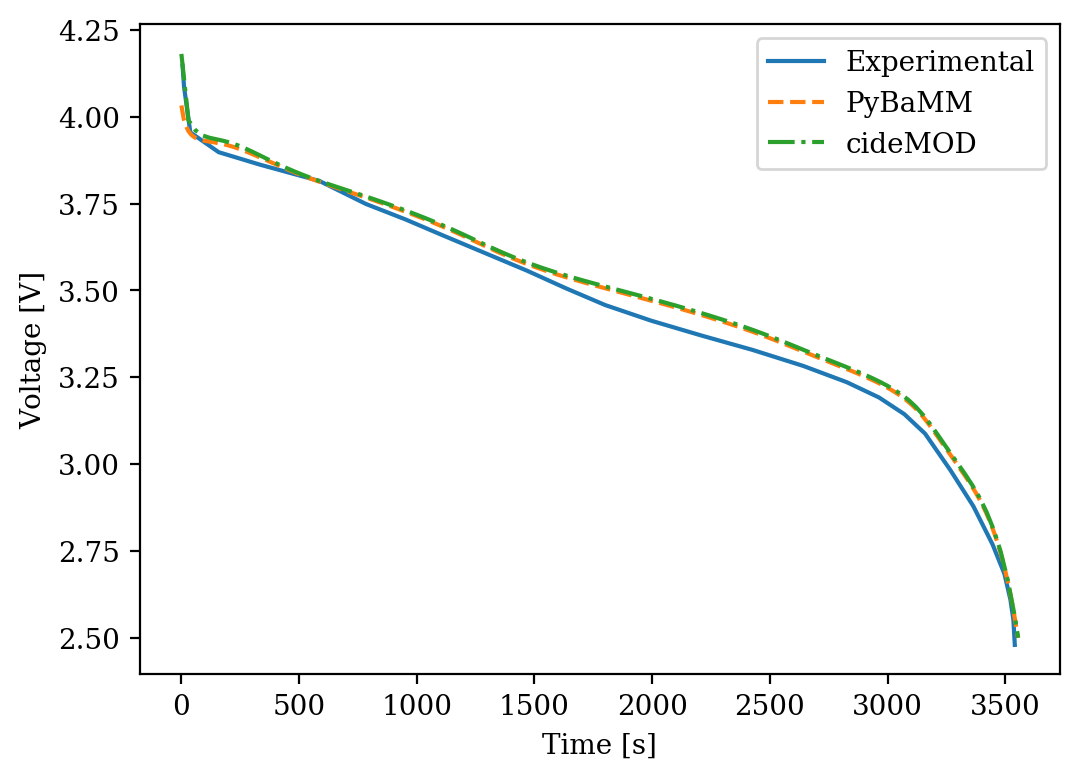

In [11]:
fig, ax1 = plt.subplots(1, 1, figsize=(5.5, 4), dpi=200)

# plot the 1C results over time
ax1.plot(voltage_data_1C[:,0], voltage_data_1C[:,1], "-")
ax1.plot(voltage_pybamm_1C[:,0], voltage_pybamm_1C[:,2], "--")
ax1.plot(problem.WH.global_var_arrays[0], problem.WH.global_var_arrays[1], "-.")
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("Voltage [V]")
ax1.legend(["Experimental", "PyBaMM", "cideMOD"], loc="best")

plt.tight_layout()
plt.show()

### Residual mean square error (RMSE)

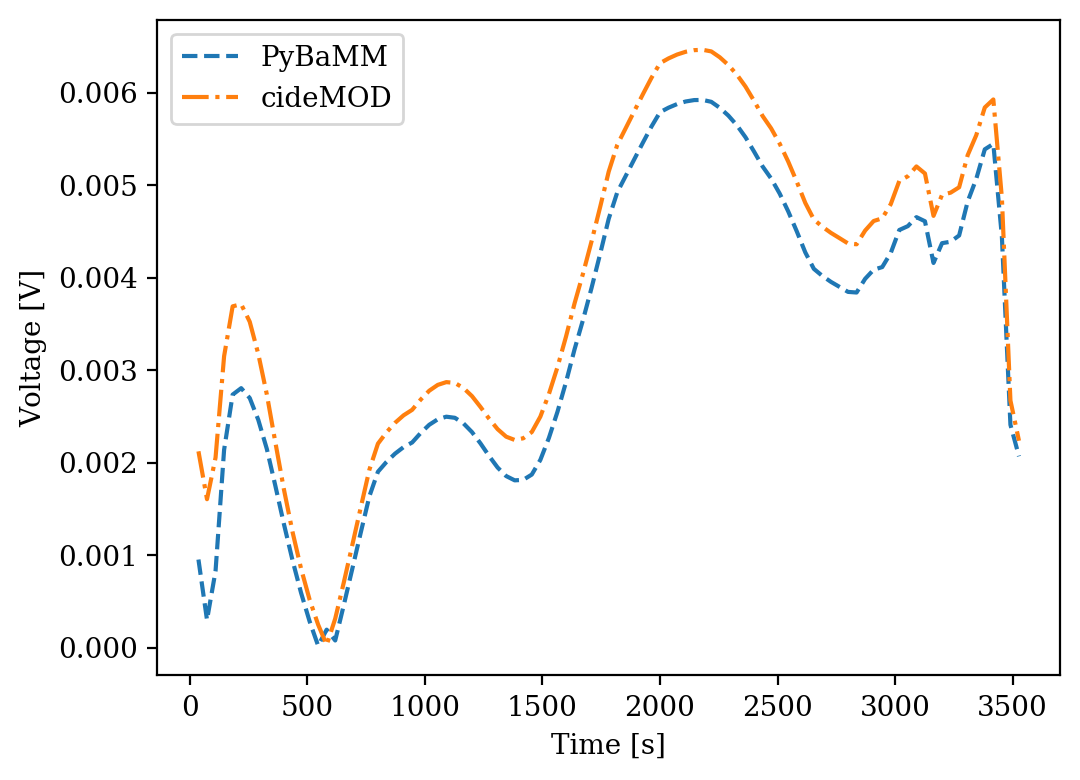

In [12]:
real = interp1d(voltage_data_1C[:,0], voltage_data_1C[:,1], bounds_error=False)
pybamm = interp1d(voltage_pybamm_1C[:,0], voltage_pybamm_1C[:,2], bounds_error=False)
cidemod = interp1d(problem.WH.global_var_arrays[0], problem.WH.global_var_arrays[1], bounds_error=False)

time = np.linspace(0, 3600, 100)

fig, ax1 = plt.subplots(1, 1, figsize=(5.5, 4), dpi=200)

# plot the RMSE over time
ax1.plot(time, np.sqrt((real(time)-pybamm(time))**2/len(time)), "--")
ax1.plot(time, np.sqrt((real(time)-cidemod(time))**2/len(time)), "-.")
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("Voltage [V]")
ax1.legend(["PyBaMM", "cideMOD"], loc="best")

plt.tight_layout()
plt.show()

In [13]:
real = interp1d(voltage_data_1C[:,0], voltage_data_1C[:,1], bounds_error=False)
pybamm = interp1d(voltage_pybamm_1C[:,0], voltage_pybamm_1C[:,2], bounds_error=False)
cidemod = interp1d(problem.WH.global_var_arrays[0], problem.WH.global_var_arrays[1], bounds_error=False)

time = np.linspace(
    max(voltage_data_1C[0,0], voltage_pybamm_1C[0,0], problem.WH.global_var_arrays[0][0]), 
    min(voltage_data_1C[-1,0], voltage_pybamm_1C[-1,0], problem.WH.global_var_arrays[0][-1]), 
    100)

# RMSE summary
rmse_pybamm = np.sqrt(np.sum((real(time)-pybamm(time))**2)/len(time))*1e3
rmse_cidemod = np.sqrt(np.sum((real(time)-cidemod(time))**2)/len(time))*1e3
peak_pybamm = np.abs(real(time)-pybamm(time)).max()*1e3
peak_cidemod = np.abs(real(time)-cidemod(time)).max()*1e3
print(tabulate([["RMSE [mV]", rmse_pybamm, rmse_cidemod], ["Peak error [mV]",peak_pybamm,peak_cidemod ]], headers = ['', 'PyBaMM', 'cideMOD'], floatfmt=".0f"))

                   PyBaMM    cideMOD
---------------  --------  ---------
RMSE [mV]              40         43
Peak error [mV]       134         81
